## Business Understanding

Contexto del negocio: Interconnect busca reducir la pérdida de clientes anticipando cancelaciones de suscripciones.

Objetivo: Desarrollar un modelo predictivo que estime si un cliente abandonará la suscripción.

Hipótesis iniciales:

Usar débito automático reduce la cancelación.

Mayor número de servicios = menor probabilidad de churn.


KPI principal:
Métrica objetivo: AUC-ROC en test set
Métricas complementarias: F1-score, precisión, recall


# Data Understanding

In [410]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler


In [411]:
contract = pd.read_csv('../data/contract.csv')
internet = pd.read_csv('../data/internet.csv')
personal = pd.read_csv('../data/personal.csv')
phone = pd.read_csv('../data/phone.csv')

Contract data

In [412]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [413]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


No existen valores nulos

In [414]:
contract['PaperlessBilling'].value_counts()

PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

In [415]:
contract['TotalCharges'].value_counts()

TotalCharges
20.2      11
          11
19.75      9
19.9       8
19.65      8
          ..
1990.5     1
7362.9     1
346.45     1
306.6      1
108.15     1
Name: count, Length: 6531, dtype: int64

In [416]:
# Transformar a binario yes/no
contract['PaperlessBilling'] = contract['PaperlessBilling'].map({'Yes': 1, 'No': 0}).astype(int)

In [417]:
contract['PaperlessBilling'].value_counts()

PaperlessBilling
1    4171
0    2872
Name: count, dtype: int64

In [418]:
# Transformar TotalCharges a decimal, se agrega 0 a los 11 registros sin datos de cargos totales
contract['TotalCharges'] = (
    contract['TotalCharges']
    .replace(' ', '0')  # Reemplaza espacios vacíos
    .astype(float)      # Convierte a float
)

In [419]:
contract['EndDate'].value_counts()

EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

In [420]:
# Transformar columnas date a datetime

def convertir_a_fecha(valor):
    try:
        return datetime.strptime(valor, "%Y-%m-%d")  # adapta el formato según tu caso
    except ValueError:
        return None

contract['BeginDate'] = contract['BeginDate'].apply(convertir_a_fecha)

In [421]:
def convertir_a_fecha_end(valor):
    try:
        dt = datetime.strptime(valor, "%Y-%m-%d %H:%M:%S")  # parsea

        return dt.date()  # devuelve solo la parte de fecha
    except Exception:
        return None

contract['EndDate'] = contract['EndDate'].apply(convertir_a_fecha_end)

In [422]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,None,Month-to-month,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,None,One year,0,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,None,One year,0,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,None,One year,1,Mailed check,84.80,1990.50
7039,2234-XADUH,2014-02-01,None,One year,1,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,2019-03-01,None,Month-to-month,1,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60


In [423]:
type(contract['BeginDate'][0])

pandas._libs.tslibs.timestamps.Timestamp

Internet Data

In [424]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [425]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [426]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3186-AJIEK,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [427]:
print(internet['OnlineBackup'].unique())


['Yes' 'No']


In [428]:
# Transformar variables binarias a 1-0
internet['OnlineBackup'] = internet['OnlineBackup'].map({'Yes': 1, 'No': 0}).astype(int)
internet['OnlineSecurity'] = internet['OnlineSecurity'].map({'Yes': 1, 'No': 0}).astype(int)
internet['DeviceProtection'] = internet['DeviceProtection'].map({'Yes': 1, 'No': 0}).astype(int)
internet['TechSupport'] = internet['TechSupport'].map({'Yes': 1, 'No': 0}).astype(int)
internet['StreamingTV'] = internet['StreamingTV'].map({'Yes': 1, 'No': 0}).astype(int)
internet['StreamingMovies'] = internet['StreamingMovies'].map({'Yes': 1, 'No': 0}).astype(int)

In [429]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,1,0,1,1,1,1
5513,2234-XADUH,Fiber optic,0,1,1,0,1,1
5514,4801-JZAZL,DSL,1,0,0,0,0,0
5515,8361-LTMKD,Fiber optic,0,0,0,0,0,0


In [430]:
# Verificar duplicados
internet['customerID'].duplicated().value_counts()

customerID
False    5517
Name: count, dtype: int64

Personal

In [431]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [432]:
personal['Partner'] = personal['Partner'].map({'Yes': 1, 'No': 0}).astype(int)
personal['Dependents'] = personal['Dependents'].map({'Yes': 1, 'No': 0}).astype(int)

In [433]:
personal['customerID'].duplicated().value_counts()

customerID
False    7043
Name: count, dtype: int64

Phone

In [434]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [435]:
phone['customerID'].duplicated().value_counts()

customerID
False    6361
Name: count, dtype: int64

In [436]:
phone['MultipleLines'] = phone['MultipleLines'].map({'Yes': 1, 'No': 0}).astype(int)

In [437]:
phone.describe()

,MultipleLines
count,6361.000000
mean,0.467065
std,0.498953
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# Data Preparation

Unificar dataset

In [438]:
for name, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f"{name} - columnas: {df.columns.tolist()}")
    print(f"{name} - duplicados customerID: {df['customerID'].duplicated().sum()}\n")


contract - columnas: ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
contract - duplicados customerID: 0

personal - columnas: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
personal - duplicados customerID: 0

internet - columnas: ['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
internet - duplicados customerID: 0

phone - columnas: ['customerID', 'MultipleLines']
phone - duplicados customerID: 0



In [439]:
# Unificar df
df = contract.merge(personal, on='customerID', how='inner')
df = df.merge(internet, on='customerID', how='inner')
df = df.merge(phone, on='customerID', how='inner')


In [440]:
print(df.shape)

(4835, 20)


In [441]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,None,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,0
1,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,0
2,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0
3,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,1,Electronic check,99.65,820.50,Female,0,0,0,Fiber optic,0,0,1,0,1,1,1
4,1452-KIOVK,2018-04-01,None,Month-to-month,1,Credit card (automatic),89.10,1949.40,Male,0,0,1,Fiber optic,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,2018-07-01,None,Month-to-month,1,Bank transfer (automatic),78.70,1495.10,Male,0,0,0,Fiber optic,0,0,0,0,1,0,0
4831,6840-RESVB,2018-02-01,None,One year,1,Mailed check,84.80,1990.50,Male,0,1,1,DSL,1,0,1,1,1,1,1
4832,2234-XADUH,2014-02-01,None,One year,1,Credit card (automatic),103.20,7362.90,Female,0,1,1,Fiber optic,0,1,1,0,1,1,1
4833,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,Male,1,1,0,Fiber optic,0,0,0,0,0,0,1


In [442]:
print(df.isna().sum().sort_values(ascending=False))  # Ver columnas con más nulos

EndDate             3249
customerID             0
BeginDate              0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64


In [443]:
# Reemplazar NaT en endDate con la fecha actual
fecha_hoy = datetime.today().date()

df['EndDate'] = df['EndDate'].fillna(fecha_hoy)

In [444]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [445]:
df['Type'].value_counts()

Type
Month-to-month    2975
One year           964
Two year           896
Name: count, dtype: int64

In [446]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

type_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df['Type'] = df['Type'].map(type_mapping)

# One-hot encoding
df = pd.get_dummies(df, columns=['PaymentMethod', 'InternetService'], drop_first=True)


In [447]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic
0,5575-GNVDE,2017-04-01,2025-05-12,1,0,56.95,1889.50,1,0,0,...,0,1,0,0,0,0,False,False,True,False
1,3668-QPYBK,2019-10-01,2019-12-01,0,1,53.85,108.15,1,0,0,...,1,0,0,0,0,0,False,False,True,False
2,9237-HQITU,2019-09-01,2019-11-01,0,1,70.70,151.65,0,0,0,...,0,0,0,0,0,0,False,True,False,True
3,9305-CDSKC,2019-03-01,2019-11-01,0,1,99.65,820.50,0,0,0,...,0,1,0,1,1,1,False,True,False,True
4,1452-KIOVK,2018-04-01,2025-05-12,0,1,89.10,1949.40,1,0,0,...,1,0,0,1,0,1,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,2018-07-01,2025-05-12,0,1,78.70,1495.10,1,0,0,...,0,0,0,1,0,0,False,False,False,True
4831,6840-RESVB,2018-02-01,2025-05-12,1,1,84.80,1990.50,1,0,1,...,0,1,1,1,1,1,False,False,True,False
4832,2234-XADUH,2014-02-01,2025-05-12,1,1,103.20,7362.90,0,0,1,...,1,1,0,1,1,1,True,False,False,True
4833,8361-LTMKD,2019-07-01,2019-11-01,0,1,74.40,306.60,1,1,1,...,0,0,0,0,0,1,False,False,True,True


Feature Engineering

In [448]:
# agregar target Churn

# El cliente abandonó si EndDate ya pasó
df['Churn'] = (df['EndDate'] < fecha_hoy).astype(int)

In [449]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,Churn
0,5575-GNVDE,2017-04-01,2025-05-12,1,0,56.95,1889.50,1,0,0,...,1,0,0,0,0,False,False,True,False,0
1,3668-QPYBK,2019-10-01,2019-12-01,0,1,53.85,108.15,1,0,0,...,0,0,0,0,0,False,False,True,False,1
2,9237-HQITU,2019-09-01,2019-11-01,0,1,70.70,151.65,0,0,0,...,0,0,0,0,0,False,True,False,True,1
3,9305-CDSKC,2019-03-01,2019-11-01,0,1,99.65,820.50,0,0,0,...,1,0,1,1,1,False,True,False,True,1
4,1452-KIOVK,2018-04-01,2025-05-12,0,1,89.10,1949.40,1,0,0,...,0,0,1,0,1,True,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,2018-07-01,2025-05-12,0,1,78.70,1495.10,1,0,0,...,0,0,1,0,0,False,False,False,True,0
4831,6840-RESVB,2018-02-01,2025-05-12,1,1,84.80,1990.50,1,0,1,...,1,1,1,1,1,False,False,True,False,0
4832,2234-XADUH,2014-02-01,2025-05-12,1,1,103.20,7362.90,0,0,1,...,1,0,1,1,1,True,False,False,True,0
4833,8361-LTMKD,2019-07-01,2019-11-01,0,1,74.40,306.60,1,1,1,...,0,0,0,0,1,False,False,True,True,1


In [450]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'Churn'],
      dtype='object')

In [451]:
bool_cols = [
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check',
    'InternetService_Fiber optic'
]

# Convertir todas a 0/1 (int)
df[bool_cols] = df[bool_cols].astype(int)

# Modeling

In [452]:
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,Churn
0,5575-GNVDE,2017-04-01,2025-05-12,1,0,56.95,1889.50,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,3668-QPYBK,2019-10-01,2019-12-01,0,1,53.85,108.15,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,9237-HQITU,2019-09-01,2019-11-01,0,1,70.70,151.65,0,0,0,...,0,0,0,0,0,0,1,0,1,1
3,9305-CDSKC,2019-03-01,2019-11-01,0,1,99.65,820.50,0,0,0,...,1,0,1,1,1,0,1,0,1,1
4,1452-KIOVK,2018-04-01,2025-05-12,0,1,89.10,1949.40,1,0,0,...,0,0,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,8456-QDAVC,2018-07-01,2025-05-12,0,1,78.70,1495.10,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4831,6840-RESVB,2018-02-01,2025-05-12,1,1,84.80,1990.50,1,0,1,...,1,1,1,1,1,0,0,1,0,0
4832,2234-XADUH,2014-02-01,2025-05-12,1,1,103.20,7362.90,0,0,1,...,1,0,1,1,1,1,0,0,1,0
4833,8361-LTMKD,2019-07-01,2019-11-01,0,1,74.40,306.60,1,1,1,...,0,0,0,0,1,0,0,1,1,1


In [453]:
df.drop(columns=['customerID', 'BeginDate', 'EndDate'], inplace=True)

Balanceo

In [454]:
# Ver distribución de clases
clase_counts = df['Churn'].value_counts(normalize=True)
print("Distribución de Churn:")
print(clase_counts)


porcentaje_yes = clase_counts.get(1, 0) * 100
print(f"\nPorcentaje de Churn='Yes': {porcentaje_yes:.2f}%")


Distribución de Churn:
Churn
0    0.671975
1    0.328025
Name: proportion, dtype: float64

Porcentaje de Churn='Yes': 32.80%


Separacion

In [455]:

X = df.drop(['Churn'], axis=1)
y = df['Churn']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Escalamos solo las columnas numéricas
num_cols = ['MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


lineal- logistic regression

In [456]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')

print("AUC-ROC promedio (LogReg):", scores_lr.mean())

lr.fit(X_train, y_train)

AUC-ROC promedio (LogReg): 0.8062515684101588


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Ensemble - random forest

In [457]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

print("AUC-ROC promedio (Random Forest):", scores_rf.mean())

rf.fit(X_train, y_train)

AUC-ROC promedio (Random Forest): 0.7950663998461356


RandomForestClassifier(class_weight='balanced', random_state=42)

Boosting

In [458]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE solo al set de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc')

print("AUC-ROC promedio (XGBoost):", scores_xgb.mean())

xgb.fit(X_train, y_train)

/Users/lucianavaldivieso/Code/Universidad/Data_mining/Examen_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:15:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lucianavaldivieso/Code/Universidad/Data_mining/Examen_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:15:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lucianavaldivieso/Code/Universidad/Data_mining/Examen_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:15:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lucianavaldivieso/Code/Universidad/Data_mining/Examen_final/

AUC-ROC promedio (XGBoost): 0.780252267080461


/Users/lucianavaldivieso/Code/Universidad/Data_mining/Examen_final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:15:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [459]:
def evaluar_modelo(modelo, nombre, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"\n Evaluación para {nombre}")
    print(f"AUC-ROC     : {auc:.4f}")
    print(f"Accuracy    : {acc:.4f}")
    print(f"F1 Score    : {f1:.4f}")
    print(f"Precision   : {prec:.4f}")
    print(f"Recall      : {rec:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



 Evaluación para Regresión Logística
AUC-ROC     : 0.8237
Accuracy    : 0.7292
F1 Score    : 0.6603
Precision   : 0.5609
Recall      : 0.8025


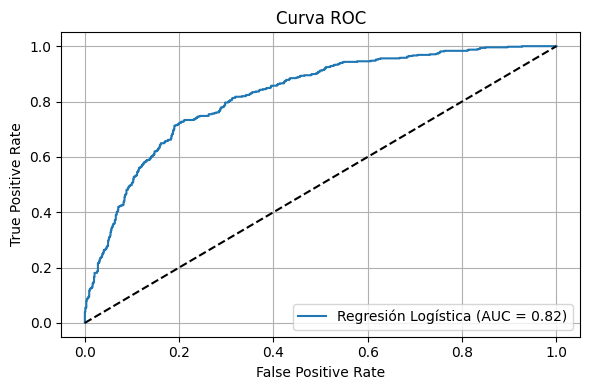


 Evaluación para Random Forest
AUC-ROC     : 0.8018
Accuracy    : 0.7588
F1 Score    : 0.5863
Precision   : 0.6703
Recall      : 0.5210


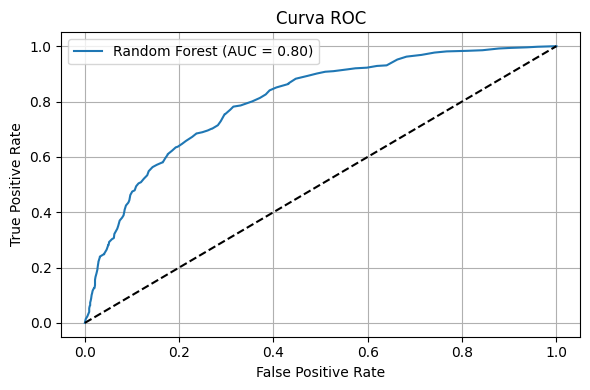


 Evaluación para XGBoost
AUC-ROC     : 0.7781
Accuracy    : 0.7243
F1 Score    : 0.5643
Precision   : 0.5860
Recall      : 0.5441


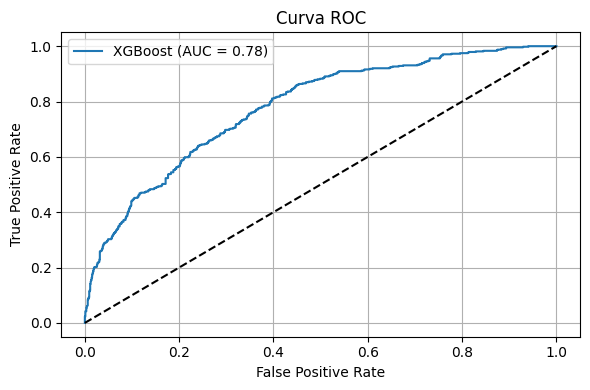

In [460]:
evaluar_modelo(lr, "Regresión Logística", X_test, y_test)
evaluar_modelo(rf, "Random Forest", X_test, y_test)
evaluar_modelo(xgb, "XGBoost", X_test, y_test)


In [462]:
import joblib
import os

# Crear la carpeta si no existe
os.makedirs("models", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Guardar cada modelo
joblib.dump(lr, "../models/modelo_logistica.joblib")
joblib.dump(rf, "../models/modelo_random_forest.joblib")
joblib.dump(xgb, "../models/modelo_xgboost.joblib")


['../models/modelo_xgboost.joblib']

SHAP

/Users/lucianavaldivieso/Code/Universidad/Data_mining/Examen_final/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


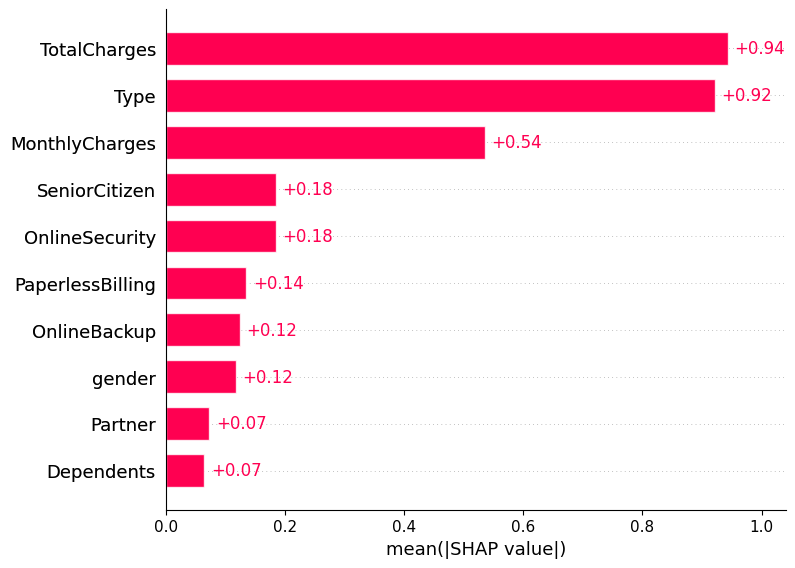

In [461]:
import shap

# Crea el explainer usando el modelo entrenado
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Visualiza los 10 features más importantes
shap.plots.bar(shap_values[:, :10], max_display=10)




1. **TotalCharges**: clientes con cargos totales más bajos tienden a abandonar, indicando poca antigüedad o uso.
2. **Type**: los contratos más cortos (mes a mes) están fuertemente asociados al churn.
3. **MonthlyCharges**: cargos mensuales altos también elevan la probabilidad de abandono.
4. **SeniorCitizen** y **OnlineSecurity**: muestran un impacto medio pero significativo.
5. **PaperlessBilling**, **OnlineBackup**, **gender**, **Partner**, y **Dependents** tienen un efecto menor pero no despreciable.


Proximos pasos